In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

metric = 'auc_relaxed'

dataset = 'kws'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

In [7]:
files_auc_complete = [
    f'{base_path}/{metric}_SHAP_{{}}_samples{{}}_{intersection}_{{}}.tsv',
    f'{base_path}/{metric}_LR_{{}}_samples{{}}_{intersection}_{{}}.tsv',
    f'{base_path}/{metric}_RF_{{}}_samples{{}}_{intersection}_{{}}.tsv',
]

names = ['zeros', 'noise']
# samples = [100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 10000, 12000, 14000, 18000]
samples = [100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 6000, 8000]
methods = ['SHAP', 'LR', 'RF']
error_margins = [0, 0.05, 0.06, 0.07, 0.08, 0.09]
df_combinations = []

for method, file_template in zip(methods, files_auc_complete):
    for name, n_sample, error_margin in itertools.product(names, samples, error_margins):
        file_path = file_template.format(name, n_sample, error_margin)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            df_combination['n_sample'] = n_sample
            df_combination['error_margin'] = error_margin
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [8]:
final_df_combination

,filename,event_label,actual_score,real_order,model_order,roc_auc,true_markers,method,name,n_sample,error_margin
0,121-127105-0024.flac,0.0,1.838884,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0.22266184 0.15195881 -0.24904287 0.172137...,0.992958,"[[11.95, 12.16]]",SHAP,zeros,100,0.00
1,5683-32866-0030.flac,0.0,19.714678,[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-0.9853045 6.03681373 -2.3157104 -9.923898...,0.500000,"[[0.36, 0.62]]",SHAP,zeros,100,0.00
2,260-123286-0025.flac,0.0,10.521505,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-2.96999036 0.89274342 2.85632968 -1.712606...,0.966292,"[[5.26, 5.56]]",SHAP,zeros,100,0.00
3,1995-1826-0026.flac,0.0,3.494040,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. ...,[ 2.6866996 -0.61972961 0.58487246 -0.034763...,0.990066,"[[1.25, 1.51]]",SHAP,zeros,100,0.00
4,1221-135767-0009.flac,0.0,9.973760,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 1.47542861 0.99274331 -0.27085957 0.418241...,0.988550,"[[5.9, 6.12]]",SHAP,zeros,100,0.00
...,...,...,...,...,...,...,...,...,...,...,...
21595,5683-32866-0005.flac,0.0,19.838762,[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. ...,[0.00242501 0.002462 0.00235718 0.00426642 0...,0.987805,"[[0.8, 1.22]]",RF,noise,8000,0.09
21596,1221-135766-0011.flac,0.0,11.235601,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.00268557 0.00325903 0.00471906 0.00389403 0...,0.974482,"[[5.41, 5.87]]",RF,noise,8000,0.09
21597,672-122797-0002.flac,0.0,1.021959,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.00238786 0.00212627 0.00240286 0.00225054 0...,0.979008,"[[6.96, 7.43]]",RF,noise,8000,0.09
21598,5142-36377-0014.flac,0.0,6.686018,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.00302838 0.00304673 0.00187062 0.00170295 0...,0.972000,"[[14.08, 14.45]]",RF,noise,8000,0.09


In [9]:
resumen = final_df_combination.groupby(['method', 'name', 'n_sample', 'error_margin'])[value].mean().reset_index()
resumen

,method,name,n_sample,error_margin,roc_auc
0,LR,noise,100,0.00,0.925207
1,LR,noise,100,0.05,0.906137
2,LR,noise,100,0.06,0.891390
3,LR,noise,100,0.07,0.886808
4,LR,noise,100,0.08,0.869095
...,...,...,...,...,...
427,SHAP,zeros,8000,0.05,0.991363
428,SHAP,zeros,8000,0.06,0.987592
429,SHAP,zeros,8000,0.07,0.985686
430,SHAP,zeros,8000,0.08,0.981134


Veamos primero que, para todos explicadores, la curva del AUC cuando error_margin = 0 es mayor que para cualquier error_margin != 0. Nos acercamos a experimentar para el Teorema 1.


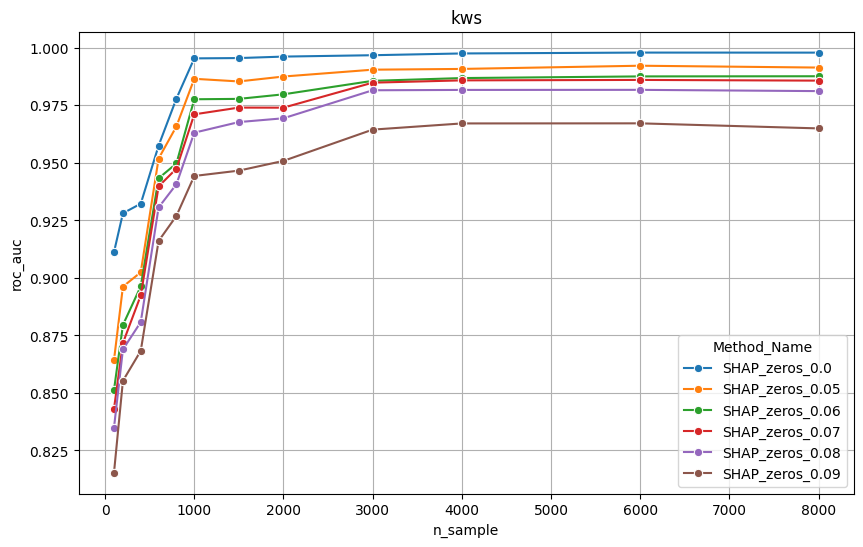

In [12]:
mean_auc_df_combination = final_df_combination.groupby(['method', 'name', 'n_sample', 'error_margin'])[value].mean().reset_index()
mean_auc_df_combination = mean_auc_df_combination[(mean_auc_df_combination['method'] == "SHAP") & (mean_auc_df_combination['name'] == "zeros")]
mean_auc_df_combination = pd.DataFrame(mean_auc_df_combination) 

# Create a grouping column combining method and name
mean_auc_df_combination["group"] = mean_auc_df_combination["method"] + "_" + mean_auc_df_combination["name"] + "_" + mean_auc_df_combination["error_margin"].astype(str)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_auc_df_combination, x="n_sample", y="roc_auc", hue="group", marker="o")
plt.title(dataset)
plt.xlabel("n_sample")
plt.ylabel("roc_auc")
plt.legend(title="Method_Name")
plt.grid(True)
plt.show()

¿Se cumple el Teorema 2? Dado dos explicadores evaluados con error_margin se cumple que se mantiene el ranking cuando los evaluamos antes el GT real? (error_margin = 0)

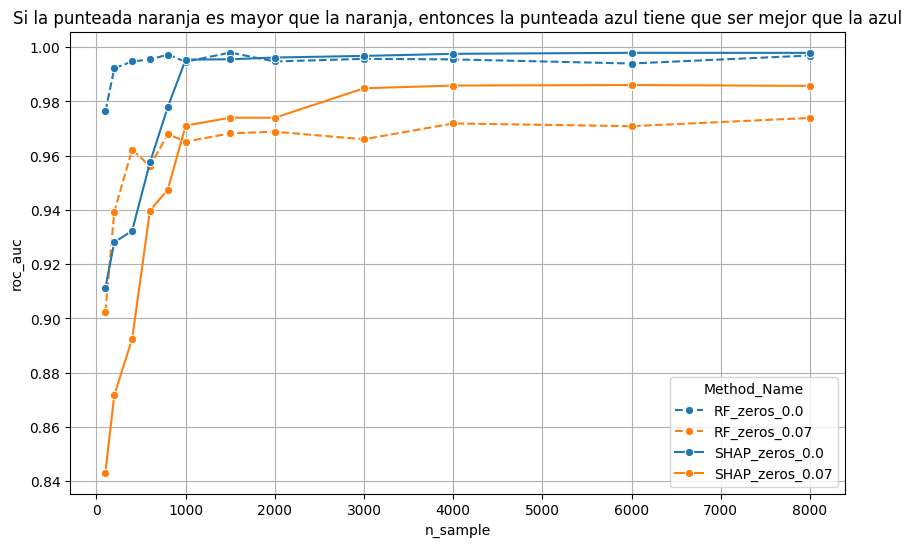

In [13]:
method1 = "RF"
name1 = "zeros"

method2 = "SHAP"
name2 = "zeros"
margin = 0.07

mean_auc_df_combination = final_df_combination.groupby(['method', 'name', 'n_sample', 'error_margin'])[value].mean().reset_index()

mean_auc_df_combination_1 = mean_auc_df_combination[(mean_auc_df_combination['method'] == method1) & (mean_auc_df_combination['name'] == name1)]
mean_auc_df_combination_1 = mean_auc_df_combination_1[(mean_auc_df_combination_1['error_margin'] == margin) | (mean_auc_df_combination_1['error_margin'] == 0)]
mean_auc_df_combination_1 = pd.DataFrame(mean_auc_df_combination_1) 

mean_auc_df_combination_2 = mean_auc_df_combination[(mean_auc_df_combination['method'] == method2) & (mean_auc_df_combination['name'] == name2)]
mean_auc_df_combination_2 = mean_auc_df_combination_2[(mean_auc_df_combination_2['error_margin'] == margin) | (mean_auc_df_combination_2['error_margin'] == 0)]
mean_auc_df_combination_2 = pd.DataFrame(mean_auc_df_combination_2) 

# Create a grouping column combining method and name
mean_auc_df_combination_1["group"] = mean_auc_df_combination_1["method"] + "_" + mean_auc_df_combination_1["name"] + "_" + mean_auc_df_combination_1["error_margin"].astype(str)
mean_auc_df_combination_2["group"] = mean_auc_df_combination_2["method"] + "_" + mean_auc_df_combination_2["name"] + "_" + mean_auc_df_combination_2["error_margin"].astype(str)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_auc_df_combination_1, x="n_sample", y="roc_auc", hue="group", marker="o", linestyle='--')
sns.lineplot(data=mean_auc_df_combination_2, x="n_sample", y="roc_auc", hue="group", marker="o")

plt.title("Si la punteada naranja es mayor que la naranja, entonces la punteada azul tiene que ser mejor que la azul")
plt.xlabel("n_sample")
plt.ylabel("roc_auc")
plt.legend(title="Method_Name")
plt.grid(True)
plt.show()